## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from skopt import BayesSearchCV

from library.sb_utils import save_file

## Load Data

In [2]:
bank_data=pd.read_csv('../data/bank_data_features.csv')

In [3]:
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Check out the data type to prepare for the next pre-processing step.

In [4]:
bank_data.dtypes

Attrition_Flag                int64
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

## Train-Test Split

In [5]:
X =bank_data.drop(columns=['Attrition_Flag'])
y =bank_data.Attrition_Flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666,stratify=y)

## Preorocessing

This dataset includes both numerical and categorical features. Most machine learning algorithms require data to be on the same scale for them to be effective, so in here we use StandardSclaler to scale our numerical data. On the other hand, for categorical features, we use one-hot encoding to transform categorical data into numerical so that we can apply our Machine Learning algorithms without any problems.

In [6]:
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
cat_ix = X.select_dtypes(include=['object']).columns

In [7]:
col_transform = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_ix), ('num', StandardScaler(), num_ix)])

## Resampling

According to EDA we know that this is an imbanlanced dataset, the minority class accounts for 16.1%. A widely adopted technique for dealing with highly unbalanced datasets is called resampling. In here we are introducing oversampling this technique to resample our data later.

In [8]:
over_sampling=SMOTE()

## Model Selection

We are going to try the following algorithms for our model. Among them, Logistic Regression is gradient descent based algorithm, Random Forest and XGBoost are tree-based, SVM and KNN are distance-based.
1. Logistic Regression
2. Random Forest
3. XGBoost
4. KNN
5. SVM with linear kernel
6. SVM with RBF kernel 

At the same time, we will apply Stratified K-Fold Cross Validation on our training data to estimate the skill of our machine learning models.

### Logistic Regression

In [9]:
LR_pipe = Pipeline(steps=[('preprocessor', col_transform),('oversampling',over_sampling),('LR_model', LogisticRegression(max_iter=500))])

In [10]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(LR_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("Logistic Regression cross validation", score + " : "+ str(cvs))
    

Logistic Regression cross validation roc_auc : 0.926304725168756
Logistic Regression cross validation f1 : 0.6452385035723862
Logistic Regression cross validation precision : 0.5231715402098269
Logistic Regression cross validation recall : 0.8385245901639344
Logistic Regression cross validation accuracy : 0.8529295589203423


### Random Forest

In [11]:
RF_pipe= Pipeline(steps=[('preprocessor', col_transform), ('oversampling',over_sampling),('RF_model', RandomForestClassifier())])

In [12]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(RF_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("Random Forest cross validation", score + " : "+ str(cvs))

Random Forest cross validation roc_auc : 0.9848807457409194
Random Forest cross validation f1 : 0.8507769601666922
Random Forest cross validation precision : 0.8678245817046036
Random Forest cross validation recall : 0.8401639344262295
Random Forest cross validation accuracy : 0.9545753785385122


### XGBoost

In [13]:
XGB_pipe= Pipeline(steps=[('preprocessor', col_transform),('oversampling',over_sampling), ('XGB_model', XGBClassifier())])

In [14]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(XGB_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("XGBoost cross validation", score + " : "+ str(cvs))

XGBoost cross validation roc_auc : 0.9910684667309546
XGBoost cross validation f1 : 0.9045067967361271
XGBoost cross validation precision : 0.9091208042163856
XGBoost cross validation recall : 0.8926229508196721
XGBoost cross validation accuracy : 0.9681369321922316


### KNN

In [15]:
KNN_pipe= Pipeline(steps=[('preprocessor', col_transform),('oversampling',over_sampling), ('KNN_model', KNeighborsClassifier(n_neighbors=8))])

In [16]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(KNN_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("KNN cross validation", score + " : "+ str(cvs))

KNN cross validation roc_auc : 0.9258026358084216
KNN cross validation f1 : 0.6675607159773402
KNN cross validation precision : 0.5505500682968589
KNN cross validation recall : 0.8508196721311474
KNN cross validation accuracy : 0.8578011849901251


### SVM with linear kernel

In [17]:
SVMlnr_pipe= Pipeline(steps=[('preprocessor', col_transform),('oversampling',over_sampling), ('SVMlnr', SVC(kernel="linear", C=1))])

In [18]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(SVMlnr_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("SVM with linear kernel cross validation", score + " : "+ str(cvs))

SVM with linear kernel cross validation roc_auc : 0.9254586949533913
SVM with linear kernel cross validation f1 : 0.6449878406146652
SVM with linear kernel cross validation precision : 0.5176421534919167
SVM with linear kernel cross validation recall : 0.840983606557377
SVM with linear kernel cross validation accuracy : 0.8510862409479921


### SVM with RBF kernel

In [19]:
SVMrbf_pipe= Pipeline(steps=[('preprocessor', col_transform),('oversampling',over_sampling), ('SVMrbf', SVC(kernel="rbf"))])

In [20]:
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(SVMrbf_pipe, X_train, y_train,  scoring=score, cv=5,n_jobs=-1).mean()
    print("SVM with RBF kernel cross validation", score + " : "+ str(cvs))

SVM with RBF kernel cross validation roc_auc : 0.963908068145291
SVM with RBF kernel cross validation f1 : 0.7799963083183284
SVM with RBF kernel cross validation precision : 0.7209579551892292
SVM with RBF kernel cross validation recall : 0.85
SVM with RBF kernel cross validation accuracy : 0.9227123107307438


Based on the scores of all models, we find that XGBoost performs the best. Next we are going to tune the XGBoost model to find the optimal values of hyperparameters and maximize the model performance.

## Model Tuning

We choose Bayesian Optimization to tune the model. For XGBoost, we are going to tune the following parameters:<br>
max_depth: Maximum depth of a tree. <br>
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. <br>
min_child_weight: Minimum sum of instance weight (hessian) needed in a child. <br>
learning_rate: Step size shrinkage used in update to prevents overfitting. <br>
n_estimators: The number of runs XGBoost will try to learn.<br>

In [21]:
XGB_space = {'XGB_model__max_depth': (3,10), 
             'XGB_model__gamma': (0,5),
             'XGB_model__min_child_weight':(0.5,1), 
             'XGB_model__learning_rate':(0.01,1),
             'XGB_model__n_estimators':(100,500)}

In [22]:
XGB_search = BayesSearchCV( estimator=XGB_pipe,search_spaces=XGB_space,n_iter = 10,n_jobs=-1,cv=5, scoring='recall',
     verbose = 0)

In [23]:
XGB_search.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          OneHotEncoder(),
                                                                          Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon...
                                                       min_child_weight=None,
                                                       missing=nan,
                                        

In [24]:
print(XGB_search.best_score_)
print(XGB_search.best_params_)

0.9000000000000001
OrderedDict([('XGB_model__gamma', 5), ('XGB_model__learning_rate', 0.73183237565908), ('XGB_model__max_depth', 7), ('XGB_model__min_child_weight', 0.7517848198520114), ('XGB_model__n_estimators', 142)])


In [25]:
XGB_tuned= XGB_search.best_estimator_

In [26]:
print(classification_report(y_test, XGB_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2125
           1       0.88      0.88      0.88       407

    accuracy                           0.96      2532
   macro avg       0.93      0.93      0.93      2532
weighted avg       0.96      0.96      0.96      2532



## Feature Importance

In [27]:
onehot=pd.DataFrame(bank_data.drop(bank_data[cat_ix],axis =1)).merge(pd.get_dummies(bank_data[cat_ix]),left_index=True,right_index=True)
features=onehot.drop(columns=['Attrition_Flag'])

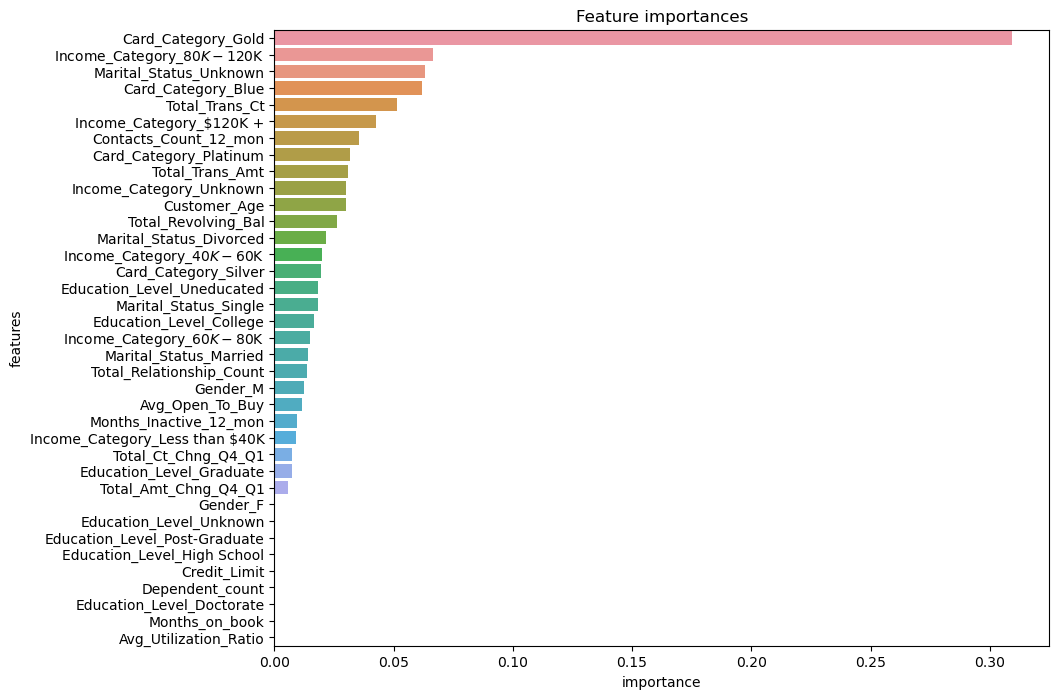

In [28]:
feature_importance=pd.DataFrame(XGB_search.best_estimator_[2].feature_importances_, columns=['importance'])
feature_importance['features'] =features.columns
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()